# Seq2Seq
Eng -> Fra

# 1. 문자수준

## 1.1 데이터 전처리

In [3]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os

from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
file_path = './data/seq2seq/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
print('전체 샘플의 수: ', len(lines))
lines.sample(5)

전체 샘플의 수:  217975


,eng,fra,cc
159928,You probably just want to be alone.,Vous voulez probablement juste être seul.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
117735,Tom said that he didn't know.,Tom a dit qu'il ne savait pas.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
148617,Do you have to do this very often?,Dois-tu faire ça très souvent ?,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
35566,Tom is John's twin.,Tom est le jumeau de John.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
184470,"Sometimes, I feel like I can do anything.",J'ai parfois le sentiment que je suis capable ...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...


cc column 불필요, 훈련 데이터는 5만개의 샘플로 줄이기

In [5]:
lines = lines[['eng', 'fra']][:50000] # 5만개 사용
lines.sample(5)

,eng,fra
21573,No one will know.,Personne ne saura.
2585,Tom's busy.,Tom a à faire.
8729,"Quiet, please.","Silence, s'il vous plaît !"
42527,Tom brought me here.,Tom m'a amené ici.
4820,Fear nothing.,N'aie aucune crainte.


seq2seq 동작을 위하여 디코더의 입력과 예측에 $\texttt{<sos>}$, $\texttt{<eos>}$ 넣어주기

In [6]:
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x: '\t ' + x + ' \n')
print('전체 샘플의 수 : ', len(lines))
lines.sample(5)

전체 샘플의 수 :  50000


,eng,fra
799,Terrific!,\t Au poil ! \n
39104,I didn't expect you.,\t Je ne m'attendais pas à te voir. \n
39916,I took this picture.,\t J'ai pris cette photo. \n
24027,You were perfect.,\t Vous avez été parfaite. \n
14022,Can I park here?,\t Je peux me garer ici ? \n


단어장을 만들고 각 단어에 부여된 고유한 정수로 텍스트 시퀀스를 정수 시퀀스로 변환하는 정수 인코딩 과정. 이때 영어, 프랑스어 각각 다로 만들어준다.

In [7]:
eng_tokenizer = Tokenizer(char_level=True) #문자 단위로 토크나이징
eng_tokenizer.fit_on_texts(lines.eng) # 50000개의 행을 가진 fra의 각 행에 토믄화
input_text = eng_tokenizer.texts_to_sequences(lines.eng) # 단어를 숫자값 인덱스로 변환하여 저장

fra_tokenizer = Tokenizer(char_level=True) #문자 단위로 토크나이징
fra_tokenizer.fit_on_texts(lines.fra) # 50000개의 행을 가진 fra의 각 행에 토믄화
target_text = fra_tokenizer.texts_to_sequences(lines.fra) # 단어를 숫자값 인덱스로 변환하여 저장

input_text[:3], target_text[:3]

([[19, 4, 7], [19, 4, 7], [19, 4, 7]],
 [[10, 1, 19, 5, 1, 31, 1, 11],
  [10, 1, 15, 5, 12, 16, 29, 2, 14, 1, 11],
  [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]])

단어장의 크기를 변수로 저장, 0번 토큰을 고려하여 +1을 하고 저장.

In [8]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print(f"영어 단어장 크기: {eng_vocab_size}, 프랑스 단어장 크기: {fra_vocab_size}")

영어 단어장 크기: 52, 프랑스 단어장 크기: 73


영어 데이터와 프랑스어 데이터의 최대 길이 각각 구해보기(패딩하기 위해서)

In [9]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])
print(f"영어 seq의 최대 길이: {max_eng_seq_len}, 프랑스 seq의 최대 길이: {max_fra_seq_len}")

영어 seq의 최대 길이: 21, 프랑스 seq의 최대 길이: 69


In [10]:
# 전체 통계
print('전체 샘플의 수 : ', len(lines))
print(f"영어 단어장 크기: {eng_vocab_size}, 프랑스 단어장 크기: {fra_vocab_size}")
print(f"영어 seq의 최대 길이: {max_eng_seq_len}, 프랑스 seq의 최대 길이: {max_fra_seq_len}")

전체 샘플의 수 :  50000
영어 단어장 크기: 52, 프랑스 단어장 크기: 73
영어 seq의 최대 길이: 21, 프랑스 seq의 최대 길이: 69


인코더의 입력으로 사용되는 시퀀스와 달리, 프랑스어 시퀀스는 2가지 버전으로 나누어 준비해야 한다.  
1. 디코더의 출력과 비교해야 할 정답 데이터 - sos 토큰이 필요 없다
2. Teacher forcing을 위해 디코더의 입력으로 사용하기 위한 것 - eos 토큰이 필요 없다  
ex) 'I am a person' -> 'Je suis une personne'  
훈련과정)  '$\texttt{<sos>}$ Je suis une personne'를 입력, 'Je suis une personne $\texttt{<eos>}$'를 예측

In [11]:
encoder_input = input_text
# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index[eos_token]] for line in target_text]
# 시작 토큰 제거
decoder_target = [[char for char in line if char != fra_tokenizer.word_index[sos_token]] for line in target_text]

In [12]:
print(decoder_input[:3])
print(decoder_target[:3])

[[10, 1, 19, 5, 1, 31, 1], [10, 1, 15, 5, 12, 16, 29, 2, 14, 1], [10, 1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1]]
[[1, 19, 5, 1, 31, 1, 11], [1, 15, 5, 12, 16, 29, 2, 14, 1, 11], [1, 2, 7, 1, 12, 9, 8, 4, 2, 1, 31, 1, 11]]


decoder_input 숫자 10(sos 토큰)으로 시작 11(eos 토큰)삭제  
decoder_target 숫자 10(sos 토큰)으로 삭제 11(eos 토큰)로 끝남

In [13]:
encoder_input = pad_sequences(encoder_input, maxlen = max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen = max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen = max_fra_seq_len, padding='post')
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21)
프랑스어 입력데이터의 크기(shape) : (50000, 69)
프랑스어 출력데이터의 크기(shape) : (50000, 69)


In [14]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)
print('영어 데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 21, 52)
프랑스어 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 출력데이터의 크기(shape) : (50000, 69, 73)


In [15]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기(shape) :',np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기(shape) :',np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기(shape) :',np.shape(decoder_target))

영어 학습데이터의 크기(shape) : (50000, 21, 52)
프랑스어 학습 입력데이터의 크기(shape) : (50000, 69, 73)
프랑스어 학습 출력데이터의 크기(shape) : (50000, 69, 73)


## 1.2 모델 학습


In [16]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model

인코더 설계: LSTM의 마지막 time step의 hidden state와 cell state를 디코더 LSTM의 첫번째 hidden state와 cell state로 전달해준다.

In [17]:
# 입력 텐서 생성
encoder_inputs = Input(shape=(None, eng_vocab_size))

# hidden size가 256인 인코더의 LSTM 셀 생성
encoder_lstm = LSTM(units=256, return_state=True)

# 디코더로 전달할 hidden state, cell state를 리턴. encoder outputs는 여기서 불필요함.
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)

# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도 저장.
encoder_states = [state_h, state_c]

디코더 설계: 동일

In [18]:
# 입력 텐서 생성
decoder_inputs = Input(shape=(None, fra_vocab_size))

# hidden 256 인코더 lstm 셀 생성
decoder_lstm = LSTM(units=256, return_sequences=True, return_state=True)

# decoder_outputs는 모든 time step의 hidden state
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

디코더 출력층 설계: 매 time step마다 다중 클래스 분류 문제이므로 프랑스어 단어장으로부터 한가지 문자만 선택하도록

In [19]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

모델 정의

In [20]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 52)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 256), (None, 316416      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 lstm[0][1]                   

pydot을 설치, graphviz는 conda install로 설치

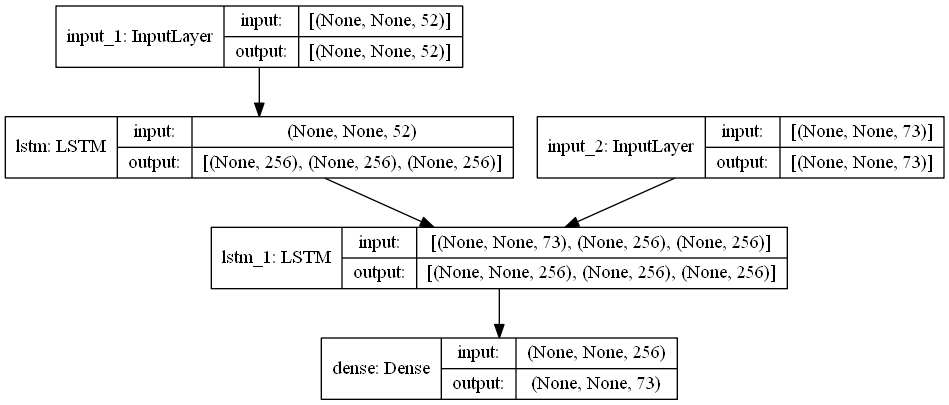

In [22]:
plot_model(model, expand_nested=True, show_shapes=True)

In [23]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train,
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
368/368 [==============================] - 6s 8ms/step - loss: 0.9519 - val_loss: 0.8274
Epoch 2/50
368/368 [==============================] - 2s 6ms/step - loss: 0.5890 - val_loss: 0.6765
Epoch 3/50
368/368 [==============================] - 2s 6ms/step - loss: 0.4877 - val_loss: 0.5968
Epoch 4/50
368/368 [==============================] - 2s 6ms/step - loss: 0.4256 - val_loss: 0.5361
Epoch 5/50
368/368 [==============================] - 2s 6ms/step - loss: 0.3847 - val_loss: 0.4921
Epoch 6/50
368/368 [==============================] - 2s 6ms/step - loss: 0.3557 - val_loss: 0.4653
Epoch 7/50
368/368 [==============================] - 2s 6ms/step - loss: 0.3335 - val_loss: 0.4517
Epoch 8/50
368/368 [==============================] - 2s 6ms/step - loss: 0.3160 - val_loss: 0.4272
Epoch 9/50
368/368 [==============================] - 2s 6ms/step - loss: 0.3016 - val_loss: 0.4234
Epoch 10/50
368/368 [==============================] - 2s 6ms/step - loss: 0.2896 - val_loss: 0.4053

## 1.3 모델 테스트

* seq2seq는 훈련단계와 테스트 단계의 동작이 다르다. 이를 위해 테스트 단계의 디코더 모델은 설계를 다시 해줄 필요가 있다.  
* 훈련 시에는 학습해야 할 타겟 문장을 디코더 모델의 입력, 출력 시퀀스로 넣어주고, 디코더 모델이 타겟 문장을 한꺼번에 출력하게 할 수 있다. 하지만 테스트 단계에서는 하나의 문장을 만들어내기 위해 루프를 돌며 단어를 하나씩 차례차례 예측하면서, 예측된 단어가 다음 입력으로 재사용되는 과정이 반복되기 때문이다.
정리하자면 다음과 같다:  
1. 인코더에 입력 문장을 넣어서 마지막 time step의 hidden, cell state를 얻는다.
2. $\texttt{<sos>}$ 토큰인 '\t'를 디코더에 입력한다.
3. 이전 time step의 출력층의 예측 결과를 현재 time step의 입력으로 한다.
4. 3을 반복하다가 $\texttt{<eos>}$ 토큰인 '\n'이 예측되면 이를 중단한다.

In [40]:
# 인코더 정의
encoder_model = Model(inputs = encoder_inputs, outputs = encoder_states)
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 52)]        0         
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 316416    
Total params: 316,416
Trainable params: 316,416
Non-trainable params: 0
_________________________________________________________________


디코더 설계

In [48]:
# 이전 time step의 states 저장
decoder_state_input_h = Input(shape=(256, ))
decoder_state_input_c = Input(shape=(256, ))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# decoder state의 초깃값으로 이전 step 사용
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]

In [49]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model = Model(inputs=[decoder_inputs] + decoder_states_inputs, outputs=[decoder_outputs] + decoder_states)
decoder_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 input_7[0][0]              

In [43]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [50]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 원-핫 벡터 생성
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, fra2idx['\t']] = 1.

    stop_condition = False
    decoded_sentence = ""

    # stop_condition이 True가 될 때까지 루프 반복
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 문자로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = idx2fra[sampled_token_index]

        # 현재 시점의 예측 문자를 예측 문장에 추가
        decoded_sentence += sampled_char

        # <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_fra_seq_len):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1, 1, fra_vocab_size))
        target_seq[0, 0, sampled_token_index] = 1.

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [51]:
import numpy as np
for seq_index in [3,50,100,300,1001]: # 입력 문장의 인덱스 (자유롭게 선택해 보세요)
    input_seq = encoder_input[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print(35 * "-")
    print('입력 문장:', lines.eng[seq_index])
    print('정답 문장:', lines.fra[seq_index][1:len(lines.fra[seq_index])-1]) # '\t'와 '\n'을 빼고 출력
    print('번역기가 번역한 문장:', decoded_sentence[:len(decoded_sentence)-1]) # '\n'을 빼고 출력

-----------------------------------
입력 문장: Go.
정답 문장:  Bouge ! 
번역기가 번역한 문장:  sortez. 
-----------------------------------
입력 문장: Hello!
정답 문장:  Bonjour ! 
번역기가 번역한 문장:  salut ! 
-----------------------------------
입력 문장: Got it!
정답 문장:  Compris ! 
번역기가 번역한 문장:  cagne ! 
-----------------------------------
입력 문장: Goodbye.
정답 문장:  Au revoir. 
번역기가 번역한 문장:  salutite. 
-----------------------------------
입력 문장: Hands off.
정답 문장:  Pas touche ! 
번역기가 번역한 문장:  pas touche. 
